In [2]:
import pandas as pd
import numpy as np
from os import path

import matplotlib.pyplot as plt
#import to draw correlation line on plot
from numpy.polynomial.polynomial import polyfit

#correlation
from scipy import stats


#use Mygene to get gene symbol
import mygene

#to measure distance between expression matrices
from scipy.spatial import distance_matrix

import random

In [2]:
#import prediction data
df_pred = pd.read_csv("predicted_expression.txt", sep='\t')

In [3]:
df_pred

,FID,IID,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273372,ENSG00000273373,ENSG00000273419,ENSG00000273432,ENSG00000273448,ENSG00000273449,ENSG00000273486,ENSG00000273487,ENSG00000273489,ENSG00000273492
0,DE02AAAZIMD114960,DE02AAAZIMD114960,0.355349,-0.495591,0.000000,-0.131417,0.000000,-0.525619,-0.029283,0.012352,...,0.155704,0.121636,-0.064487,-0.695400,-0.020224,-0.330325,0.857170,-0.109751,0.025205,-0.252383
1,DE02AAAZIMD115445,DE02AAAZIMD115445,-0.096067,-0.399099,0.051874,0.092410,0.000000,-0.670714,-0.029283,-0.324730,...,-0.339705,0.121244,-0.055414,-0.260980,-0.128740,-0.421088,0.588237,-0.111412,0.210354,0.136805
2,DE02AAAZIMD116124,DE02AAAZIMD116124,0.183565,-0.335212,0.025937,-0.128548,-0.032334,-0.780249,-0.029283,-0.184391,...,0.064869,0.103020,-0.077703,0.089522,-0.154384,-0.263763,0.000000,-0.153024,0.109149,0.280930
3,DE02AAAZIMD116318,DE02AAAZIMD116318,0.321019,0.132153,0.000000,-0.275246,0.000000,-1.346701,-0.029283,0.000000,...,0.028479,0.036625,-0.055414,0.116402,0.026146,-0.570284,0.588237,-0.144270,0.028242,-0.784274
4,DE02AAAZIMD117094,DE02AAAZIMD117094,0.000000,-0.002250,0.025937,-0.027818,-0.056410,-0.566207,-0.058565,-0.326184,...,0.199529,0.122743,-0.113305,-0.420097,0.009621,-0.603983,0.265020,-0.047498,0.217124,0.227205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,deaaazim22046,deaaazim22046,0.177861,-0.399803,0.025937,0.097194,0.000000,-1.252252,-0.058565,-0.512454,...,0.291705,0.063313,-0.017358,-0.387972,-0.126107,-0.335001,0.323217,-0.135459,0.219281,-0.411560
1248,deaaazim22132,deaaazim22132,0.000000,-0.103281,0.025937,0.110826,-0.056410,-0.672097,-0.029283,-0.324730,...,0.137499,0.049174,-0.085312,-0.038646,0.009621,-0.361963,0.265020,-0.054875,-0.116684,-0.837619
1249,deaaazim22135,deaaazim22135,0.058357,0.190831,0.000000,0.028900,0.000000,-0.100249,-0.029283,0.000000,...,0.186461,0.074358,-0.115759,-0.428607,0.004165,-0.353328,0.693605,0.106097,0.253485,-0.789750
1250,deaaazim22140,deaaazim22140,0.174971,0.046125,-0.000191,0.241929,-0.056410,-0.496782,-0.029283,-0.638808,...,0.077881,0.014142,-0.001689,-0.117763,-0.126107,-0.371683,0.530041,-0.144270,-0.131517,0.015304


#  GEXCOMP stuff

In [30]:
#import ips RNA-Seq data after exporting from .rds and store in df_ips
df_gexcomp = pd.read_csv(path.join("bulk Seq", "ips_norm_expression.tsv"), sep="\t").round()
#trim every thing from (.) on from all colnames
df_gexcomp.columns  = [colname.split(".")[0] for colname in df_gexcomp.columns]

In [61]:
genes = df_gexcomp.columns[2:-3]
genes

Index(['ENSG00000233750', 'ENSG00000237683', 'ENSG00000241860',
       'ENSG00000241599', 'ENSG00000228463', 'ENSG00000237094',
       'ENSG00000236679', 'ENSG00000231709', 'ENSG00000230021',
       'ENSG00000223659',
       ...
       'ENSG00000198886', 'ENSG00000210176', 'ENSG00000210184',
       'ENSG00000210191', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000210194', 'ENSG00000198727', 'ENSG00000210195',
       'ENSG00000210196'],
      dtype='object', length=40950)

In [62]:
sub1_orig = df_gexcomp.iloc[0,:4000].values.tolist()
len(sub1_orig)

4000

In [97]:
sub1_pred = []

domains = 20
domain_size = int(len(sub1_orig) / domains)


for i in range(domains):
    if random.choice(["good", "bad"]) == "good":
        for j in range(0, domain_size, 1):
            diff = random.randrange(1, 150, 1) # consider this diff as good estimation
            pos = (i * domain_size) + j
            #print(pos)
            sub1_pred.append(max(0, (sub1_orig[pos] + diff) if random.choice(["+", "-"]) == "+" else (sub1_orig[pos] - diff)))
    else:
        for j in range(0, domain_size, 1):
            diff = random.randrange(2, 3, 1) # consider this diff as bad estimation
            pos = (i * domain_size) + j
            #print(pos)
            sub1_pred.append(max(0, (sub1_orig[pos] * diff) if random.choice(["+", "-"]) == "+" else round(sub1_orig[pos] / diff)))
            
len(sub1_pred)

4000

In [98]:
n_selected_genes = min(len(sub1_orig), len(sub1_pred))


arr_content = np.zeros(shape=(2, n_selected_genes))

arr_content[0] = sub1_orig[:n_genes]
arr_content[1] = sub1_pred[:n_genes]

df_gexcomp = pd.DataFrame(arr_content, columns=genes[:n_selected_genes])

df_gexcomp.to_csv("gexcomp/gexcomp/media/runs/1/data.csv")

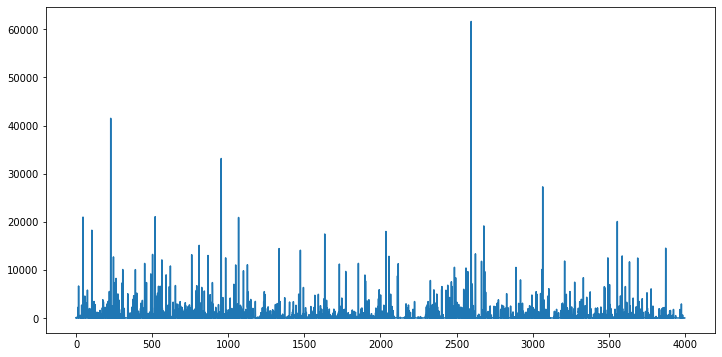

In [91]:
plt.figure(figsize=(12,6))
plt.plot(arr_content[0])

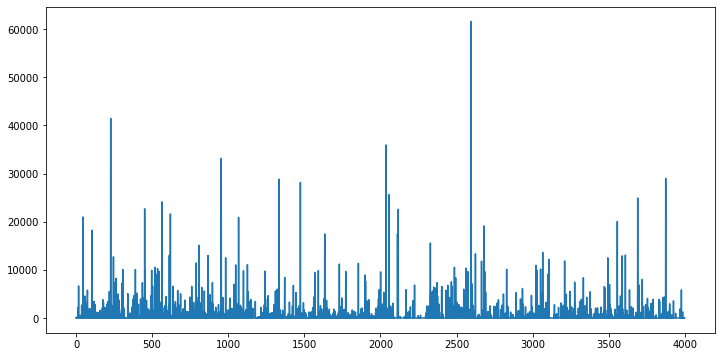

In [92]:
plt.figure(figsize=(12,6))
plt.plot(arr_content[1])

# GEXCOMP for all samples

In [40]:
#import ips RNA-Seq data after exporting from .rds and store in df_ips
df_gexcomp = pd.read_csv(path.join("bulk Seq", "ips_norm_expression.tsv"), sep="\t").round()
#trim every thing from (.) on from all colnames
df_gexcomp.columns  = [colname.split(".")[0] for colname in df_gexcomp.columns]
df_gexcomp = df_gexcomp.groupby(['cell_line', 'condition']).mean().reset_index()
del df_gexcomp['cell_line']
del df_gexcomp['condition']
del df_gexcomp['batch']
df_gexcomp

,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,ENSG00000231709,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,0.0,15.0,2.5,127.0,21.0,0.5,13.0,2.5,0.0,0.0,...,186367.0,100.0,62.5,18.0,80792.5,23604.5,42.0,128859.5,42.5,138.0
1,0.0,21.0,1.0,151.5,11.5,0.0,8.0,12.5,0.0,1.0,...,287318.0,198.0,126.0,31.5,136262.0,32801.5,58.0,198189.0,45.0,205.0
2,0.0,26.0,1.0,77.0,15.5,0.0,3.0,12.5,0.0,0.0,...,200028.5,138.0,95.5,17.0,85932.5,20894.0,46.5,118272.0,27.5,78.5
3,0.0,18.0,1.5,82.0,14.0,0.5,0.0,2.5,0.0,1.0,...,165189.0,112.5,56.5,13.5,56682.0,14629.0,30.5,105587.5,36.5,125.5
4,1.0,34.0,1.0,195.5,32.5,1.0,15.0,36.5,0.0,0.5,...,231430.5,87.5,46.5,17.5,96009.5,27310.0,63.5,155687.5,41.5,125.5
5,0.0,18.0,2.5,111.0,21.5,0.0,3.0,43.0,0.5,1.5,...,195903.5,110.0,63.5,15.0,61912.0,15363.0,27.5,98483.5,55.0,154.0


In [41]:
genes = df_gexcomp.columns
genes

Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000233750',
       'ENSG00000237683', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000228463', 'ENSG00000237094', 'ENSG00000236679',
       'ENSG00000231709',
       ...
       'ENSG00000198886', 'ENSG00000210176', 'ENSG00000210184',
       'ENSG00000210191', 'ENSG00000198786', 'ENSG00000198695',
       'ENSG00000210194', 'ENSG00000198727', 'ENSG00000210195',
       'ENSG00000210196'],
      dtype='object', length=40952)

In [42]:
orig = df_gexcomp.iloc[:,:4000].values
orig

array([[ 0. , 15. ,  2.5, ...,  0. ,  5.5,  0. ],
       [ 0. , 21. ,  1. , ...,  0. ,  4.5,  0. ],
       [ 0. , 26. ,  1. , ...,  0. ,  0.5,  0. ],
       [ 0. , 18. ,  1.5, ...,  0.5,  0. ,  0. ],
       [ 1. , 34. ,  1. , ...,  0.5, 11. ,  2. ],
       [ 0. , 18. ,  2.5, ...,  0. ,  5.5,  0.5]])

In [78]:
df_gexcomp_backup = df_gexcomp.copy()

In [105]:
#execute to get backup
df_gexcomp = df_gexcomp_backup.copy()

In [106]:
#generate synthetic pred data

pred = []



domains = 20
domain_size = int(orig.shape[1] / domains)


n_subjects = orig.shape[0]

for sub_idx in range(n_subjects):
    
    sub_pred = []
    
    for i in range(domains):
        if random.choice(["good", "bad"]) == "good":
            for j in range(0, domain_size, 1):
                diff = random.randrange(1, 150, 1) # consider this diff as good estimation
                pos = (i * domain_size) + j
                sub_pred.append(max(0, (orig[sub_idx,pos] + diff) if random.choice(["+", "-"]) == "+" else (orig[sub_idx, pos] - diff)))
        else:
            for j in range(0, domain_size, 1):
                diff = random.randrange(2, 3, 1) # consider this diff as bad estimation
                pos = (i * domain_size) + j
                sub_pred.append(max(0, (orig[sub_idx, pos] * diff) if random.choice(["+", "-"]) == "+" else round(orig[sub_idx, pos] / diff)))

    pred.append(sub_pred)
    
pred = np.array(pred)            

pred.shape

(6, 4000)

In [107]:
n_selected_genes = min(orig.shape[1], pred.shape[1])

arr_content = np.zeros(shape=(n_subjects * 2, n_selected_genes))

arr_content[0:n_subjects] = orig[0:n_subjects, :n_selected_genes]
arr_content[n_subjects: n_subjects * 2] = pred[0:n_subjects, :n_selected_genes]

df_gexcomp = pd.DataFrame(arr_content, columns=genes[:n_selected_genes])

#add label 
lbl_col = ["orig"] * n_subjects + ["pred"] * n_subjects
df_gexcomp.insert(0, 'label', lbl_col)

df_gexcomp.set_index('label', inplace=True)

df_gexcomp

,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,ENSG00000231709,...,ENSG00000223751,ENSG00000237667,ENSG00000228799,ENSG00000235688,ENSG00000172554,ENSG00000235403,ENSG00000236665,ENSG00000233553,ENSG00000115705,ENSG00000228613
label,,,,,,,,,,,,,,,,,,,,,
orig,0.0,15.0,2.5,127.0,21.0,0.5,13.0,2.5,0.0,0.0,...,7.5,0.5,3.5,7.5,11.5,0.0,0.0,0.0,5.5,0.0
orig,0.0,21.0,1.0,151.5,11.5,0.0,8.0,12.5,0.0,1.0,...,1.5,0.0,0.0,12.5,57.0,2.0,2.5,0.0,4.5,0.0
orig,0.0,26.0,1.0,77.0,15.5,0.0,3.0,12.5,0.0,0.0,...,1.0,0.0,0.5,7.0,4.5,0.0,0.0,0.0,0.5,0.0
orig,0.0,18.0,1.5,82.0,14.0,0.5,0.0,2.5,0.0,1.0,...,5.0,0.0,1.0,13.0,13.5,0.0,0.0,0.5,0.0,0.0
orig,1.0,34.0,1.0,195.5,32.5,1.0,15.0,36.5,0.0,0.5,...,2.0,0.5,3.0,17.0,34.5,1.0,0.5,0.5,11.0,2.0
orig,0.0,18.0,2.5,111.0,21.5,0.0,3.0,43.0,0.5,1.5,...,1.5,0.0,1.5,13.0,24.0,0.0,1.5,0.0,5.5,0.5
pred,0.0,8.0,1.0,64.0,42.0,0.0,6.0,5.0,0.0,0.0,...,0.0,0.0,34.5,0.0,0.0,0.0,0.0,0.0,0.0,95.0
pred,0.0,10.0,0.0,303.0,23.0,0.0,4.0,6.0,0.0,0.0,...,0.0,0.0,64.0,0.5,63.0,77.0,0.0,0.0,141.5,131.0
pred,0.0,0.0,0.0,156.0,120.5,38.0,148.0,119.5,19.0,0.0,...,2.0,0.0,0.0,14.0,2.0,0.0,0.0,0.0,1.0,0.0


In [108]:
df_gexcomp.reset_index(inplace=True)
df_gexcomp

,label,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,...,ENSG00000223751,ENSG00000237667,ENSG00000228799,ENSG00000235688,ENSG00000172554,ENSG00000235403,ENSG00000236665,ENSG00000233553,ENSG00000115705,ENSG00000228613
0,orig,0.0,15.0,2.5,127.0,21.0,0.5,13.0,2.5,0.0,...,7.5,0.5,3.5,7.5,11.5,0.0,0.0,0.0,5.5,0.0
1,orig,0.0,21.0,1.0,151.5,11.5,0.0,8.0,12.5,0.0,...,1.5,0.0,0.0,12.5,57.0,2.0,2.5,0.0,4.5,0.0
2,orig,0.0,26.0,1.0,77.0,15.5,0.0,3.0,12.5,0.0,...,1.0,0.0,0.5,7.0,4.5,0.0,0.0,0.0,0.5,0.0
3,orig,0.0,18.0,1.5,82.0,14.0,0.5,0.0,2.5,0.0,...,5.0,0.0,1.0,13.0,13.5,0.0,0.0,0.5,0.0,0.0
4,orig,1.0,34.0,1.0,195.5,32.5,1.0,15.0,36.5,0.0,...,2.0,0.5,3.0,17.0,34.5,1.0,0.5,0.5,11.0,2.0
5,orig,0.0,18.0,2.5,111.0,21.5,0.0,3.0,43.0,0.5,...,1.5,0.0,1.5,13.0,24.0,0.0,1.5,0.0,5.5,0.5
6,pred,0.0,8.0,1.0,64.0,42.0,0.0,6.0,5.0,0.0,...,0.0,0.0,34.5,0.0,0.0,0.0,0.0,0.0,0.0,95.0
7,pred,0.0,10.0,0.0,303.0,23.0,0.0,4.0,6.0,0.0,...,0.0,0.0,64.0,0.5,63.0,77.0,0.0,0.0,141.5,131.0
8,pred,0.0,0.0,0.0,156.0,120.5,38.0,148.0,119.5,19.0,...,2.0,0.0,0.0,14.0,2.0,0.0,0.0,0.0,1.0,0.0
9,pred,0.0,9.0,1.0,164.0,28.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0


In [109]:
#export averaged by mean of both groups 

df_gexcomp_agg = df_gexcomp.groupby(['label']).mean()

df_gexcomp_agg.to_csv("gexcomp/gexcomp/media/runs/1/data_aggregated.csv")

df_gexcomp_agg
#df_gexcomp = df_gexcomp.groupby(['label']).mean()
#df_gexcomp.
#df_gexcomp

,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,ENSG00000231709,...,ENSG00000223751,ENSG00000237667,ENSG00000228799,ENSG00000235688,ENSG00000172554,ENSG00000235403,ENSG00000236665,ENSG00000233553,ENSG00000115705,ENSG00000228613
label,,,,,,,,,,,,,,,,,,,,,
orig,0.166667,22.000000,1.583333,124.00,19.333333,0.333333,7.0,18.250000,0.083333,0.666667,...,3.083333,0.166667,1.583333,11.666667,24.166667,0.500000,0.750000,0.166667,4.500000,0.416667
pred,22.833333,38.666667,4.333333,171.75,42.750000,6.333333,29.0,37.833333,26.833333,17.416667,...,8.250000,0.166667,32.000000,4.750000,23.500000,12.833333,14.583333,0.000000,27.416667,43.416667


In [110]:
#add sample names to be used by DEG by DESeq2

#add sample
sample_col = []
for group in ["orig", "pred"]:
    for i in range(1, n_subjects + 1, 1):
        sample_col.append(group + str(i))

if 'sample' in df_gexcomp:
    del df_gexcomp['sample']
    
df_gexcomp.insert(1, 'sample', sample_col)

#now drop label, no need in DEG
if 'label' in df_gexcomp:
    del df_gexcomp['label']

#set sample col as index
df_gexcomp.set_index('sample', inplace=True)

df_gexcomp

,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,ENSG00000231709,...,ENSG00000223751,ENSG00000237667,ENSG00000228799,ENSG00000235688,ENSG00000172554,ENSG00000235403,ENSG00000236665,ENSG00000233553,ENSG00000115705,ENSG00000228613
sample,,,,,,,,,,,,,,,,,,,,,
orig1,0.0,15.0,2.5,127.0,21.0,0.5,13.0,2.5,0.0,0.0,...,7.5,0.5,3.5,7.5,11.5,0.0,0.0,0.0,5.5,0.0
orig2,0.0,21.0,1.0,151.5,11.5,0.0,8.0,12.5,0.0,1.0,...,1.5,0.0,0.0,12.5,57.0,2.0,2.5,0.0,4.5,0.0
orig3,0.0,26.0,1.0,77.0,15.5,0.0,3.0,12.5,0.0,0.0,...,1.0,0.0,0.5,7.0,4.5,0.0,0.0,0.0,0.5,0.0
orig4,0.0,18.0,1.5,82.0,14.0,0.5,0.0,2.5,0.0,1.0,...,5.0,0.0,1.0,13.0,13.5,0.0,0.0,0.5,0.0,0.0
orig5,1.0,34.0,1.0,195.5,32.5,1.0,15.0,36.5,0.0,0.5,...,2.0,0.5,3.0,17.0,34.5,1.0,0.5,0.5,11.0,2.0
orig6,0.0,18.0,2.5,111.0,21.5,0.0,3.0,43.0,0.5,1.5,...,1.5,0.0,1.5,13.0,24.0,0.0,1.5,0.0,5.5,0.5
pred1,0.0,8.0,1.0,64.0,42.0,0.0,6.0,5.0,0.0,0.0,...,0.0,0.0,34.5,0.0,0.0,0.0,0.0,0.0,0.0,95.0
pred2,0.0,10.0,0.0,303.0,23.0,0.0,4.0,6.0,0.0,0.0,...,0.0,0.0,64.0,0.5,63.0,77.0,0.0,0.0,141.5,131.0
pred3,0.0,0.0,0.0,156.0,120.5,38.0,148.0,119.5,19.0,0.0,...,2.0,0.0,0.0,14.0,2.0,0.0,0.0,0.0,1.0,0.0


In [111]:
df_gexcomp.to_csv("gexcomp/gexcomp/media/runs/1/data.csv")

In [15]:
#generate data for some gexcomp runs

# import random

# df_only_genes = 

# genes = df_pred.iloc[:0,2:].columns

# orig_exp = np.array([random.randrange(1, 100, 1) for i in range(len(genes))])
# pred_exp = np.array([random.randrange(1, 100, 1) for i in range(len(genes))])

# arr_content = np.zeros(shape=(2, len(genes)))
# arr_content[0] = orig_exp
# arr_content[1] = pred_exp

# df_gexcomp = pd.DataFrame(arr_content, columns=genes)
# df_gexcomp.to_csv("gexcomp/gexcomp/media/runs/1/data.csv")

## / Gexcomp stuff

In [5]:
#check if IIDs are unique??
df_pred.IID.is_unique

True

In [6]:
#check if we have negative values (compare normalization with other df)
(df_pred.iloc[:,2:] < 0).values.any()

True

In [7]:
#add code mapping
df_mapping = pd.read_excel("mapping B7 USI codes.xlsx")
df_mapping

,VPN,IID
0,B7_001,DE10AAAZIMD209100
1,B7_007,DE26AAAZIMD109096
2,B7_008,DE29AAAZIMD116705
3,B7_009,DE31AAAZIMD109103
4,B7_021,DE47AAAZIMD109106
5,B7_028,DE58AAAZIMD109102
6,B7_030,DEAAAZIM07932
7,B7_033,DEAAAZIM07933
8,B7_035,DEAAAZIM07934
9,B7_048,DEAAAZIM07936


In [8]:
#from df_pred drop all rows that doesn't have matching in mappping
df_pred = df_pred[df_pred['IID'].isin(df_mapping.IID.values.tolist())]
df_pred

,FID,IID,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273372,ENSG00000273373,ENSG00000273419,ENSG00000273432,ENSG00000273448,ENSG00000273449,ENSG00000273486,ENSG00000273487,ENSG00000273489,ENSG00000273492
58,DE10AAAZIMD209100,DE10AAAZIMD209100,0.180527,0.055051,0.000000,-0.131417,0.00000,-1.344408,-0.029283,-0.323030,...,0.140605,0.112566,-0.102543,-0.577501,-0.135728,-0.599992,0.323217,-0.109751,0.174756,-0.312808
176,DE26AAAZIMD109096,DE26AAAZIMD109096,-0.224657,-0.318297,0.000000,-0.130967,0.00000,-0.105055,-0.058565,0.000000,...,0.219499,0.111698,-0.002549,0.171125,0.133969,-0.596016,0.530041,-0.153024,0.135284,0.381708
202,DE29AAAZIMD116705,DE29AAAZIMD116705,0.271009,-0.330878,0.025937,-0.269384,0.00000,-1.199559,-0.029283,0.028379,...,0.054109,0.085011,-0.067036,-0.334534,0.005921,-0.586043,0.443058,-0.196298,-0.119207,-0.873625
208,DE31AAAZIMD109103,DE31AAAZIMD109103,-0.002889,0.000000,0.025937,-0.169895,-0.05641,-1.253933,-0.040451,-0.322506,...,0.010482,0.085011,-0.013216,0.098704,0.019243,-0.475282,0.323217,-0.138588,0.102507,1.015049
333,DE47AAAZIMD109106,DE47AAAZIMD109106,0.000000,-0.019743,0.051874,-0.109083,0.00000,-0.554681,0.000000,-0.184391,...,-0.526185,0.121244,-0.013216,-0.053114,0.128016,-0.603983,0.693605,-0.151098,0.135554,-0.639732
407,DE58AAAZIMD109102,DE58AAAZIMD109102,0.183565,-0.254749,0.025937,0.327890,0.00000,-0.303019,-0.029283,-0.498469,...,0.249493,0.121636,-0.004142,-0.140838,0.014269,-0.330838,0.279493,-0.047498,-0.298961,-0.659008
942,DEAAAZIM07932,DEAAAZIM07932,0.180527,-0.364421,0.000000,-0.131417,0.00000,-0.482136,0.000000,-0.324730,...,0.052814,0.085011,-0.055414,-0.766476,0.149514,-0.530220,0.321165,-0.109751,0.131824,0.894702
943,DEAAAZIM07933,DEAAAZIM07933,0.186619,-0.105674,0.000000,0.028884,0.00000,-0.536555,-0.029283,-1.131252,...,-0.027224,0.026687,-0.055414,-0.259916,0.009621,-0.356655,0.226510,-0.151098,0.136928,1.020582
944,DEAAAZIM07934,DEAAAZIM07934,0.180676,0.119642,0.000000,-0.149068,-0.05641,-0.408291,-0.029283,-0.317575,...,-0.044568,0.025580,-0.100090,0.077949,0.139688,-0.603983,0.588237,-0.047498,0.171022,0.133823
945,DEAAAZIM07936,DEAAAZIM07936,0.148862,0.169103,0.000000,-0.131417,0.00000,-0.831987,-0.058565,-0.184391,...,0.126034,0.018009,-0.026431,-0.075560,-0.000981,-0.313989,0.601246,-0.181861,0.263543,0.048381


In [9]:
df_pred["VPN"] = ""
df_pred.VPN = df_pred.apply(
    lambda row: df_mapping[df_mapping.IID == row["IID"]].iloc[0,0]
    , axis=1)
df_pred[['IID', 'VPN']]

<ipython-input-9-801b389a660a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["VPN"] = ""
/home/omar/.local/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,IID,VPN
58,DE10AAAZIMD209100,B7_001
176,DE26AAAZIMD109096,B7_007
202,DE29AAAZIMD116705,B7_008
208,DE31AAAZIMD109103,B7_009
333,DE47AAAZIMD109106,B7_021
407,DE58AAAZIMD109102,B7_028
942,DEAAAZIM07932,B7_030
943,DEAAAZIM07933,B7_033
944,DEAAAZIM07934,B7_035
945,DEAAAZIM07936,B7_048


In [10]:
#add metadata
df_meta = pd.read_excel("Kopie von DLPFC_stemcell_forSandra.xlsx")
df_meta

,VPN,DLPFC peak voxel,DLPFC cluster at p<0.01,Rangfolge,Axonlängenwachstum,Alter,Geschlecht,Unnamed: 7
0,B7_001,0.55,0.6163,16,1.57,21,0,NaN
1,B7_007,1.39,1.0275,22,2.45,23,0,NaN
2,B7_008,0.09,0.0743,4,1.48,23,0,NaN
3,B7_009,0.06,0.1849,7,1.58,24,0,NaN
4,B7_021,0.14,0.2278,8,1.52,28,0,NaN
5,B7_028,-0.18,-0.1386,2,1.32,43,0,NaN
6,B7_030,0.60,0.6019,15,1.87,20,0,NaN
7,B7_033,0.01,0.0107,3,1.18,28,1,NaN
8,B7_035,0.03,0.1502,5,1.49,22,1,NaN
9,B7_048,0.35,0.4225,12,1.48,33,1,NaN


In [11]:
df_pred["dlpfc_peak_voxel"] = 0
df_pred["dlpfc_peak_voxel"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["DLPFC peak voxel"]
    , axis=1)

df_pred["dlpfc_cluster_at_p<0.01"] = 0
df_pred["dlpfc_cluster_at_p<0.01"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["DLPFC cluster at p<0.01"]
    , axis=1)

df_pred["rangfolge"] = 0
df_pred["rangfolge"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["Rangfolge"]
    , axis=1)

df_pred["axonal_growth"] = 0
df_pred["axonal_growth"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["Axonlängenwachstum"]
    , axis=1)

df_pred["age"] = 0
df_pred["age"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["Alter"]
    , axis=1)

df_pred["sex"] = 0
df_pred["sex"] = df_pred.apply(
    lambda row: df_meta[df_meta.VPN == row["VPN"]].iloc[0]["Geschlecht"]
    , axis=1)


df_pred[['IID', 'VPN', 'dlpfc_peak_voxel', 'dlpfc_cluster_at_p<0.01', 'rangfolge', 'axonal_growth', 'age', 'sex']]

<ipython-input-11-7471af3cad1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["dlpfc_peak_voxel"] = 0
<ipython-input-11-7471af3cad1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["dlpfc_peak_voxel"] = df_pred.apply(
<ipython-input-11-7471af3cad1c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,IID,VPN,dlpfc_peak_voxel,dlpfc_cluster_at_p<0.01,rangfolge,axonal_growth,age,sex
58,DE10AAAZIMD209100,B7_001,0.55,0.6163,16,1.57,21,0
176,DE26AAAZIMD109096,B7_007,1.39,1.0275,22,2.45,23,0
202,DE29AAAZIMD116705,B7_008,0.09,0.0743,4,1.48,23,0
208,DE31AAAZIMD109103,B7_009,0.06,0.1849,7,1.58,24,0
333,DE47AAAZIMD109106,B7_021,0.14,0.2278,8,1.52,28,0
407,DE58AAAZIMD109102,B7_028,-0.18,-0.1386,2,1.32,43,0
942,DEAAAZIM07932,B7_030,0.60,0.6019,15,1.87,20,0
943,DEAAAZIM07933,B7_033,0.01,0.0107,3,1.18,28,1
944,DEAAAZIM07934,B7_035,0.03,0.1502,5,1.49,22,1
945,DEAAAZIM07936,B7_048,0.35,0.4225,12,1.48,33,1


In [12]:
#set index
#keep as col, too =). This is just Omar's style.
df_pred['VPN_col'] = df_pred['VPN']
df_pred.set_index('VPN', inplace=True)
df_pred

<ipython-input-12-6d6597b6bb9a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['VPN_col'] = df_pred['VPN']


,FID,IID,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273487,ENSG00000273489,ENSG00000273492,dlpfc_peak_voxel,dlpfc_cluster_at_p<0.01,rangfolge,axonal_growth,age,sex,VPN_col
VPN,,,,,,,,,,,,,,,,,,,,,
B7_001,DE10AAAZIMD209100,DE10AAAZIMD209100,0.180527,0.055051,0.000000,-0.131417,0.00000,-1.344408,-0.029283,-0.323030,...,-0.109751,0.174756,-0.312808,0.55,0.6163,16,1.57,21,0,B7_001
B7_007,DE26AAAZIMD109096,DE26AAAZIMD109096,-0.224657,-0.318297,0.000000,-0.130967,0.00000,-0.105055,-0.058565,0.000000,...,-0.153024,0.135284,0.381708,1.39,1.0275,22,2.45,23,0,B7_007
B7_008,DE29AAAZIMD116705,DE29AAAZIMD116705,0.271009,-0.330878,0.025937,-0.269384,0.00000,-1.199559,-0.029283,0.028379,...,-0.196298,-0.119207,-0.873625,0.09,0.0743,4,1.48,23,0,B7_008
B7_009,DE31AAAZIMD109103,DE31AAAZIMD109103,-0.002889,0.000000,0.025937,-0.169895,-0.05641,-1.253933,-0.040451,-0.322506,...,-0.138588,0.102507,1.015049,0.06,0.1849,7,1.58,24,0,B7_009
B7_021,DE47AAAZIMD109106,DE47AAAZIMD109106,0.000000,-0.019743,0.051874,-0.109083,0.00000,-0.554681,0.000000,-0.184391,...,-0.151098,0.135554,-0.639732,0.14,0.2278,8,1.52,28,0,B7_021
B7_028,DE58AAAZIMD109102,DE58AAAZIMD109102,0.183565,-0.254749,0.025937,0.327890,0.00000,-0.303019,-0.029283,-0.498469,...,-0.047498,-0.298961,-0.659008,-0.18,-0.1386,2,1.32,43,0,B7_028
B7_030,DEAAAZIM07932,DEAAAZIM07932,0.180527,-0.364421,0.000000,-0.131417,0.00000,-0.482136,0.000000,-0.324730,...,-0.109751,0.131824,0.894702,0.60,0.6019,15,1.87,20,0,B7_030
B7_033,DEAAAZIM07933,DEAAAZIM07933,0.186619,-0.105674,0.000000,0.028884,0.00000,-0.536555,-0.029283,-1.131252,...,-0.151098,0.136928,1.020582,0.01,0.0107,3,1.18,28,1,B7_033
B7_035,DEAAAZIM07934,DEAAAZIM07934,0.180676,0.119642,0.000000,-0.149068,-0.05641,-0.408291,-0.029283,-0.317575,...,-0.047498,0.171022,0.133823,0.03,0.1502,5,1.49,22,1,B7_035


In [13]:
#export for later use =)
df_pred.to_csv("predicted_expression_mapped_with_meta.tsv", sep='\t')

In [14]:
#import ips RNA-Seq data after exporting from .rds and store in df_ips
df_ips = pd.read_csv(path.join("bulk Seq", "ips_norm_expression.tsv"), sep="\t")
#trim every thing from (.) on from all colnames
df_ips.columns  = [colname.split(".")[0] for colname in df_ips.columns]
df_ips

,ENSG00000223972,ENSG00000227232,ENSG00000233750,ENSG00000237683,ENSG00000241860,ENSG00000241599,ENSG00000228463,ENSG00000237094,ENSG00000236679,ENSG00000231709,...,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196,cell_line,batch,condition
SH_028_1-1,0.000000,17.693979,0.000000,145.635060,10.888603,0.000000,5.444301,19.055055,0.00000,0.000000,...,23.138280,124956.242172,29721.801827,54.443013,174631.408233,35.387958,198.716997,028#1,1,slow
SH_028-1-2,0.000000,23.823004,2.382300,157.231828,11.911502,0.000000,10.720352,5.955751,0.00000,2.382300,...,40.499107,147568.026660,35881.017920,61.939811,221746.906286,54.792910,210.833588,028#1,2,slow
SH_033_1-1,0.000000,24.081955,1.852458,65.762262,15.745894,0.000000,3.704916,13.893436,0.00000,0.000000,...,14.819665,90110.970574,21831.218407,36.122932,121418.438261,30.565558,87.991759,033#1,1,slow
SH_033_1-2,0.000000,28.069543,0.000000,88.080291,14.518729,0.000000,1.935831,10.647068,0.00000,0.000000,...,19.358306,81753.996495,19957.445228,57.107002,115125.779635,24.197882,68.721985,033#1,2,slow
SH_066_8-1,0.899651,35.086377,0.000000,188.026997,35.086377,0.000000,15.294062,32.387425,0.00000,0.000000,...,10.795808,94714.326345,26980.524578,58.477296,154479.022186,44.082884,119.653543,066#8,1,slow
SH_066_8-2,0.900068,33.302529,1.800137,203.415446,29.702255,1.800137,15.301162,41.403144,0.00000,0.900068,...,24.301845,97305.488788,27639.298761,69.305263,156896.313754,38.702939,131.409978,066#8,2,slow
SH_112_3-1,0.000000,12.657015,0.000000,111.803630,15.821268,0.000000,2.109502,51.682810,0.00000,2.109502,...,16.876020,56628.538714,13868.923905,22.149776,90833.066307,51.682810,142.391416,112#3,1,fast
SH_112_3-2,0.000000,22.823360,4.961600,110.147519,26.792640,0.000000,3.969280,33.738880,0.99232,0.992320,...,12.900160,67194.947902,16856.539615,32.746560,106133.584181,57.554559,165.717438,112#3,2,fast
SH_007_4-1,0.000000,17.238229,1.014013,138.919844,20.280269,0.000000,11.154148,3.042040,0.00000,0.000000,...,19.266256,77775.846562,22328.576437,46.644619,135254.185651,43.602579,157.172087,007#4,1,fast
SH_007_4-2,0.000000,13.338581,3.923112,114.554875,21.969428,0.784622,14.907826,1.569245,0.00000,0.000000,...,17.261694,83809.445297,24880.377385,36.877254,122465.438757,40.800367,119.262610,007#4,2,fast


In [15]:
#check if we have negative values (compare normalization with other df)
(df_ips.iloc[:,2:-10] < 0).values.any()

False

In [16]:
#drop genes that don't show in both dfs

#match genes
gene_intersection = list(set(df_pred.columns).intersection(df_ips.columns))

df_ips_cols = list(df_ips.columns)
n_ips_genes = 0
for colname in df_ips.columns:
    if colname.startswith("ENSG"):
        if colname not in gene_intersection:
            df_ips_cols.remove(colname)
        else:
            n_ips_genes += 1
df_ips = df_ips[df_ips_cols]

#same for df_pred
df_pred_cols = list(df_pred.columns)
n_pred_genes = 0
for colname in df_pred.columns:
    if colname.startswith("ENSG"):
        if colname not in gene_intersection:
            df_pred_cols.remove(colname)
        else:
            n_pred_genes += 1
df_pred = df_pred[df_pred_cols]

print(n_ips_genes == n_pred_genes)

True


In [17]:
#export df_pred metadata to webserver after  removing gene collumns, FID and IID
exclude_cols = gene_intersection + ['FID', 'IID']
df_meta = df_pred[df_pred.columns.difference(exclude_cols)]
df_meta.to_csv("webserver/rna_pred/rna_pred/data/pred_meta.csv")
df_meta

,VPN_col,age,axonal_growth,dlpfc_cluster_at_p<0.01,dlpfc_peak_voxel,rangfolge,sex
VPN,,,,,,,
B7_001,B7_001,21,1.57,0.6163,0.55,16,0
B7_007,B7_007,23,2.45,1.0275,1.39,22,0
B7_008,B7_008,23,1.48,0.0743,0.09,4,0
B7_009,B7_009,24,1.58,0.1849,0.06,7,0
B7_021,B7_021,28,1.52,0.2278,0.14,8,0
B7_028,B7_028,43,1.32,-0.1386,-0.18,2,0
B7_030,B7_030,20,1.87,0.6019,0.60,15,0
B7_033,B7_033,28,1.18,0.0107,0.01,3,1
B7_035,B7_035,22,1.49,0.1502,0.03,5,1


In [18]:
# use mean to correct batches
try:
    del df_ips["batch"]
except:
    pass
    
df_ips_aggregated = df_ips.groupby(['cell_line', 'condition']).mean().reset_index()

df_ips_aggregated['cell_line_col'] = df_ips_aggregated['cell_line']
df_ips_aggregated.set_index('cell_line', inplace=True)

del df_ips
df_ips = df_ips_aggregated.copy()
del df_ips_aggregated

df_ips

,condition,ENSG00000227232,ENSG00000233750,ENSG00000241860,ENSG00000228463,ENSG00000235373,ENSG00000228327,ENSG00000237491,ENSG00000177757,ENSG00000225880,...,ENSG00000100258,ENSG00000025770,ENSG00000130489,ENSG00000272821,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000184319,cell_line_col
cell_line,,,,,,,,,,,,,,,,,,,,,
007#4,fast,15.288405,2.468563,21.124849,13.030987,11.968749,3.597272,23.182854,2.860874,15.843637,...,1304.480244,1939.946138,126.363295,98.514417,53.319128,55.262438,2136.166884,545.625330,117.822384,007#4
028#1,slow,20.758492,1.191150,11.400052,8.082327,9.272640,2.467263,18.376191,3.147801,17.015116,...,2733.965094,1140.256775,214.982520,54.363074,35.817795,73.930415,696.244448,788.557752,243.143638,028#1
033#1,slow,26.075749,0.926229,15.132311,2.820373,6.712878,3.325174,24.181605,0.483958,19.867672,...,2150.080498,1642.498652,161.527911,55.877257,26.096592,42.701620,449.032697,478.993805,251.895786,033#1
051#1,fast,18.169661,1.406134,13.929244,0.000000,7.396641,3.742352,20.461848,4.606389,19.165792,...,1252.869709,2606.466707,151.075313,98.156883,38.975464,42.065641,1729.895580,468.044103,109.463706,051#1
066#8,slow,34.194453,0.900068,32.394316,15.297612,12.148208,8.098736,32.395987,5.398948,19.797745,...,2165.531261,986.706096,187.173496,75.141089,142.179058,134.528894,2032.791436,1027.184322,191.666529,066#8
112#3,fast,17.740187,2.480800,21.306954,3.039391,18.329994,5.613838,22.021623,3.101822,14.856874,...,1631.923168,1925.129166,170.840090,74.249865,47.669155,76.203289,1406.395382,657.992084,220.684468,112#3


In [19]:
#from df_pred keep only 6 subjects using mapping to ips
#eg. ips_cell_line: 028#1 ---> VPN_col: B7#028
cell_lines_without_hash = [cell_line.split("#")[0] for cell_line in df_ips.cell_line_col.values.tolist()]
cell_lines_without_hash

['007', '028', '033', '051', '066', '112']

In [20]:
VPNs_to_keep = [("B7_" + cell_line_without_hash) for cell_line_without_hash in cell_lines_without_hash]
VPNs_to_keep

['B7_007', 'B7_028', 'B7_033', 'B7_051', 'B7_066', 'B7_112']

In [21]:
df_pred = df_pred[df_pred["VPN_col"].isin(VPNs_to_keep)]
df_pred

,FID,IID,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000273487,ENSG00000273489,ENSG00000273492,dlpfc_peak_voxel,dlpfc_cluster_at_p<0.01,rangfolge,axonal_growth,age,sex,VPN_col
VPN,,,,,,,,,,,,,,,,,,,,,
B7_007,DE26AAAZIMD109096,DE26AAAZIMD109096,-0.224657,-0.318297,0.000000,-0.130967,0.00000,-0.105055,-0.058565,0.000000,...,-0.153024,0.135284,0.381708,1.39,1.0275,22,2.45,23,0,B7_007
B7_028,DE58AAAZIMD109102,DE58AAAZIMD109102,0.183565,-0.254749,0.025937,0.327890,0.00000,-0.303019,-0.029283,-0.498469,...,-0.047498,-0.298961,-0.659008,-0.18,-0.1386,2,1.32,43,0,B7_028
B7_033,DEAAAZIM07933,DEAAAZIM07933,0.186619,-0.105674,0.000000,0.028884,0.00000,-0.536555,-0.029283,-1.131252,...,-0.151098,0.136928,1.020582,0.01,0.0107,3,1.18,28,1,B7_033
B7_051,DEAAAZIM08161,DEAAAZIM08161,0.180527,-0.367333,0.000000,0.025708,-0.05641,-0.573710,-0.029283,-0.312378,...,-0.152270,0.155245,-0.470544,1.17,1.0826,23,2.07,22,0,B7_051
B7_066,DEAAAZIM08269,DEAAAZIM08269,-0.002666,-0.051069,0.000000,0.018369,0.00000,-1.398041,-0.028299,-0.314078,...,-0.153024,0.140064,-0.642194,0.36,0.4144,11,1.26,20,1,B7_066
B7_112,DEAAAZIM08824,DEAAAZIM08824,-0.002666,-0.021049,0.000000,-0.343682,-0.05641,-0.507230,0.000000,0.010652,...,-0.090772,0.153810,-0.548637,0.78,0.7333,18,2.07,19,0,B7_112


In [22]:
#some plotting to check best correlation method

<AxesSubplot:ylabel='Frequency'>

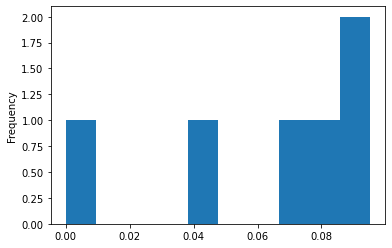

In [23]:
#check distribution to choose correct correlation method.
df_pred.iloc[:,100].plot.hist()

#let's go for spearman.

In [24]:
df_pred[['IID', 'VPN_col', 'dlpfc_peak_voxel', 'dlpfc_cluster_at_p<0.01', 'rangfolge', 'axonal_growth', 'age', 'sex']]

,IID,VPN_col,dlpfc_peak_voxel,dlpfc_cluster_at_p<0.01,rangfolge,axonal_growth,age,sex
VPN,,,,,,,,
B7_007,DE26AAAZIMD109096,B7_007,1.39,1.0275,22,2.45,23,0
B7_028,DE58AAAZIMD109102,B7_028,-0.18,-0.1386,2,1.32,43,0
B7_033,DEAAAZIM07933,B7_033,0.01,0.0107,3,1.18,28,1
B7_051,DEAAAZIM08161,B7_051,1.17,1.0826,23,2.07,22,0
B7_066,DEAAAZIM08269,B7_066,0.36,0.4144,11,1.26,20,1
B7_112,DEAAAZIM08824,B7_112,0.78,0.7333,18,2.07,19,0


In [25]:
def plot_correlation(x, y, xlabel=None, ylabel=None, annotation=None):
    # Fit with polyfit (to overlay correlation line on the plot)
    b, m = polyfit(x, y, 1)

    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    
    if xlabel != None:
        plt.xlabel(xlabel)
    if ylabel != None:
        plt.ylabel(ylabel)
        
    if annotation != None:
        # Loop for annotation of all points
        for i in range(len(x)):
            plt.annotate(annotation[i], (x[i], y[i] + 0.2))
        
    plt.show()
    
    #spearman correlation
    print("Spearman's correlation:")
    print("Correlation: ", stats.spearmanr(x, y).correlation)
    print("p-value: ", format(stats.spearmanr(x, y).pvalue, '.8f'))
    
    #pearson's correlation
    print("Pearson's correlation:")
    print("Correlation: ", stats.pearsonr(x, y)[0])
    print("p-value: ", format(stats.pearsonr(x, y)[1], '.8f'))
    
    
def df_plot_correlation(df, x, y, annotation_col=None):
    if annotation_col != None:
        plot_correlation(df[x].values, df[y].values, x, y, df[annotation_col].values.tolist())
    else:
        plot_correlation(df[x].values, df[y].values, x, y)

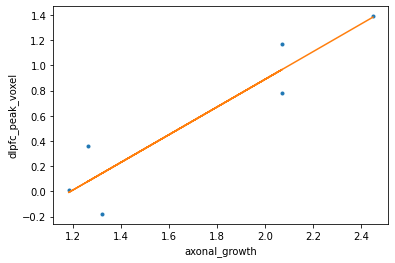

Spearman's correlation:
Correlation:  0.8116794499134278
p-value:  0.04985759
Pearson's correlation:
Correlation:  0.9322809369667681
p-value:  0.00672353


In [26]:
df_plot_correlation(df_pred, x='axonal_growth', y= 'dlpfc_peak_voxel')

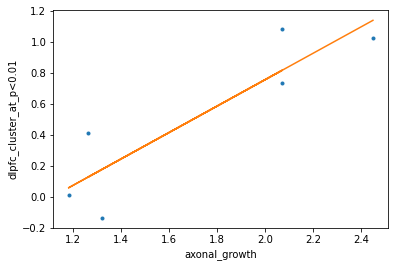

Spearman's correlation:
Correlation:  0.7247137945655605
p-value:  0.10324280
Pearson's correlation:
Correlation:  0.8898535531305334
p-value:  0.01753020


In [27]:
df_plot_correlation(df_pred, x='axonal_growth', y= 'dlpfc_cluster_at_p<0.01')

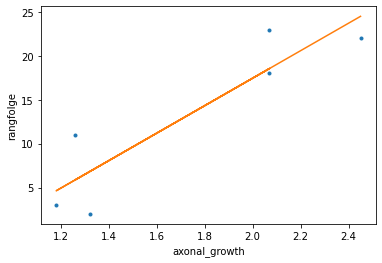

Spearman's correlation:
Correlation:  0.7247137945655605
p-value:  0.10324280
Pearson's correlation:
Correlation:  0.9044372862133896
p-value:  0.01326200


In [28]:
df_plot_correlation(df_pred, x='axonal_growth', y= 'rangfolge')

# Test expression correlation

In [29]:
len(gene_intersection)

13314

In [30]:
def calc_correlation(df_ips, df_pred, gene_intersection):
    corr_list = [] #list of list: [gene, correlation, pvalue]
    
    df_ips_exp = df_ips[gene_intersection]
    df_pred_exp = df_pred[gene_intersection]
    
    for gene in gene_intersection:
        
        #use Mygene to get gene symbol
        #mg = mygene.MyGeneInfo()
        #gene_symbol = ""
        #try:
        #    mg.query(gene, scopes='ensembl.transcript')["hits"][0]["symbol"]
        #except:
        #    gene_symbol = "Unknown"
        
        
        #assert columns are in same order
        assert((df_ips_exp.columns.values == df_pred_exp.columns.values).all())
        
        ips_gene_exp = df_ips_exp[gene].values.round(decimals=3)
        pred_gene_exp = df_pred_exp[gene].values.round(decimals=3)
        
        #Spearman's corr
        res = stats.spearmanr(ips_gene_exp, pred_gene_exp)
        corr = res.correlation
        pval = format(res.pvalue, '.8f')
        
        ips_exp = ips_gene_exp.tolist()
        pred_exp = pred_gene_exp.tolist()
        
        corr_list.append([gene, corr, pval, ips_exp, pred_exp])
        
    df_corr = pd.DataFrame(corr_list, columns =['gene', 'corr', 'pval', 'ips_exp', 'pred_exp'])
    df_corr.dropna(inplace=True)
    
    #important for sorting.
    df_corr["corr_abs"] = np.abs(df_corr["corr"])
    
    #sort: corr(desc) then pval(asc)
    df_corr.sort_values(['corr_abs', 'pval'], ascending=[False, True], inplace=True)
    return df_corr

In [31]:
# let's try spearmans corr between 6 vs 6 on a gene pair-wise level

groups = []
groups.append(df_pred.VPN_col.values.tolist())

for group in groups: #groups is a list of VPNs
    df_pred_group = df_pred[df_pred["VPN_col"].isin(group)]
    
    
    print("Correlating iPS cell lines against following VPNs from predicted expression: ", group)
    df_corr = calc_correlation(df_ips, df_pred_group, gene_intersection)
    print(df_corr)

Correlating iPS cell lines against following VPNs from predicted expression:  ['B7_007', 'B7_028', 'B7_033', 'B7_051', 'B7_066', 'B7_112']


/home/omar/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                  gene  corr        pval  \
560    ENSG00000107779  -1.0  0.00000000   
2981   ENSG00000183624   1.0  0.00000000   
3762   ENSG00000171055   1.0  0.00000000   
4013   ENSG00000178401   1.0  0.00000000   
4029   ENSG00000262814   1.0  0.00000000   
...                ...   ...         ...   
12982  ENSG00000164897   0.0  1.00000000   
13027  ENSG00000233967   0.0  1.00000000   
13051  ENSG00000217488   0.0  1.00000000   
13152  ENSG00000273045   0.0  1.00000000   
13203  ENSG00000113838   0.0  1.00000000   

                                                 ips_exp  \
560    [825.44, 849.044, 1141.664, 1233.178, 1234.603...   
2981   [1079.953, 1008.646, 1621.376, 1474.359, 795.9...   
3762   [1161.288, 1306.665, 1746.989, 1086.583, 959.6...   
4013         [7.587, 26.543, 9.533, 4.13, 19.796, 2.047]   
4029   [350.197, 375.094, 392.442, 455.807, 215.067, ...   
...                                                  ...   
12982  [678.448, 960.578, 887.265, 911.647, 752.289

# Let's measure distance between ips and pred epression values

## NOTE: that we can improve distance measure by creating a measure that measures the overall distance in a way where a pairwise-gene distance can't compense for another

In [32]:
def calc_norm(df_ips, df_pred, gene_intersection):
    
    df_ips_exp = df_ips[gene_intersection]
    df_pred_exp = df_pred[gene_intersection]
        
    #assert columns in expression DFs are identical (same genes)
    assert((df_ips_exp.columns.values == df_pred_exp.columns.values).all())

    ips_exp = df_ips_exp.values.round(decimals=3)
    pred_exp = df_pred_exp.values.round(decimals=3)
        
    #calculate distance (default ecludian)
    dist = np.linalg.norm(ips_exp-pred_exp)        

    #another way to measure
    #dist = distance_matrix(ips_exp, pred_exp).sum()

    return dist

In [33]:
def calc_dist_special(df_ips, df_pred, gene_intersection):
    
    df_ips_exp = df_ips[gene_intersection]
    df_pred_exp = df_pred[gene_intersection]
        
    #assert columns in expression DFs are identical (same genes)
    assert((df_ips_exp.columns.values == df_pred_exp.columns.values).all())

    ips_exp = df_ips_exp.values.round(decimals=3)
    pred_exp = df_pred_exp.values.round(decimals=3)
        
    #calculate distance
    dist = 0 #just for now
    
    #another way to measure
    #dist = distance_matrix(ips_exp, pred_exp).sum()

    return dist

In [34]:
def calc_dist(df_ips, df_pred, gene_intersection, win_start=None, win_len=None):

    df_ips_exp = df_ips[gene_intersection]
    df_pred_exp = df_pred[gene_intersection]
    
    #assert columns in expression DFs are identical (same genes)
    assert((df_ips_exp.columns.values == df_pred_exp.columns.values).all())
    
    if win_start != None and win_len != None:
        df_ips_exp = df_ips_exp.iloc[:,win_start:min(len(gene_intersection), win_start + win_len)]
        df_pred_exp = df_pred_exp.iloc[:,win_start:min(len(gene_intersection), win_start + win_len)]
        gene_intersection = gene_intersection[win_start:min(len(gene_intersection), win_start + win_len)]
    
    ips_exp = df_ips_exp.values.round(decimals=3)
    pred_exp = df_pred_exp.values.round(decimals=3)
        
    #calculate distance matrix (default ecludian)
    dist_matrix = distance_matrix(ips_exp, pred_exp)
    dist_matrix = np.abs(ips_exp - pred_exp)
    
    #calc dist
    #positions = np.array(range(1, len(gene_intersection) + 1))
    dist = np.sum(dist_matrix)# * (len(gene_intersection))
    
    
    #top 10 worst predicted genes
    worst_pred_genes = [gene_intersection[idx] + " ({0})".format(idx) for idx in (dist_matrix[0].argsort()[-10:][::-1]).tolist()]

    return dist, dist_matrix, worst_pred_genes

In [35]:
#Let's measure expression matrices distance between each 1 ips vs 1 pred in selected windows
def calc_dist_win(df_ips, df_pred, gene_intersection, win_start, win_len):
    dist_list = []
    dist_matrices = []

    plot_legends = []


    #easieast way to limit iterations to window size
    iteration = 0
    
    for ips_idx, row in  df_ips.iterrows():
        code = row["cell_line_col"].split("#")[0]
        pred_code = "B7_" + code

        df_ips_sub = df_ips[df_ips.index == ips_idx]
        df_pred_sub = df_pred[df_pred.index == pred_code]

        dist, dist_matrix, worst_pred_genes = calc_dist(df_ips_sub, df_pred_sub, gene_intersection, 
                                                        win_start=win_start, win_len=win_len)

        dist_matrices.append(dist_matrix)

        dist_list.append([ips_idx, pred_code, dist])

        plot_legends.append(code)

        iteration+=1
        if iteration >= win_len or win_start + iteration >= len(gene_intersection):
            break


    df_dist = pd.DataFrame(dist_list, columns =['ips_cell_line', 'pred_VPN', 'exp_distance'])
    df_dist.dropna(inplace=True)
    
    #standarize distances [0, 100]
    dist_min = 0
    dist_max = df_dist["exp_distance"].max()
    df_dist["exp_distance"] = round((df_dist["exp_distance"] - dist_min) / (dist_max - dist_min) * 100, 2)
    

    #sort
    df_dist.sort_values(['exp_distance'], ascending=[True], inplace=True)

    #plot all in one
    plt.figure(figsize=(16,9))
    colors = ['black', 'red', 'blue', 'orange', 'green', 'purple']
    x = range(win_start, win_start + len(dist_matrices[0].flatten()))
    plt.xticks(x)
    for i in range(len(df_ips)):
        plt.plot(x, dist_matrices[i].flatten(), color = colors[i])

    plt.legend(plot_legends)
    plt.show()


    print(df_dist)

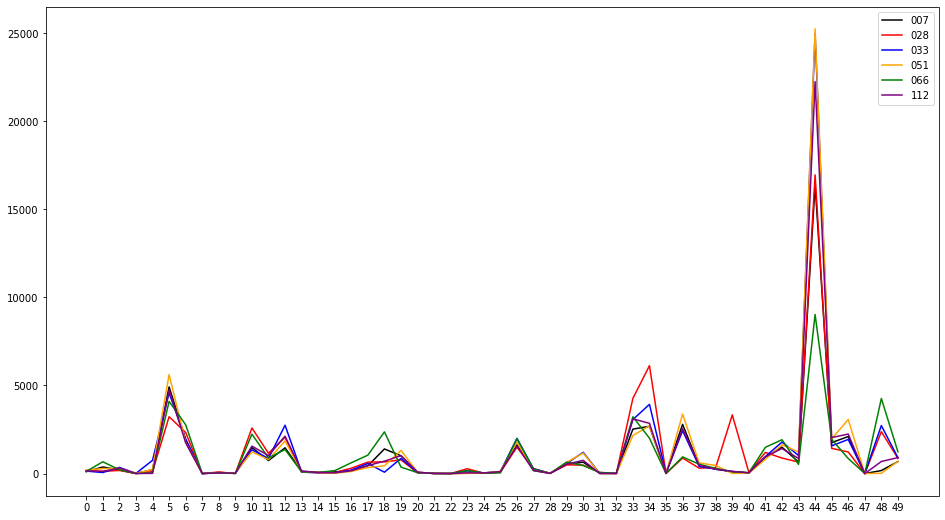

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         75.53
0         007#4   B7_007         78.29
5         112#3   B7_112         89.60
1         028#1   B7_028         90.08
3         051#1   B7_051         96.21
2         033#1   B7_033        100.00


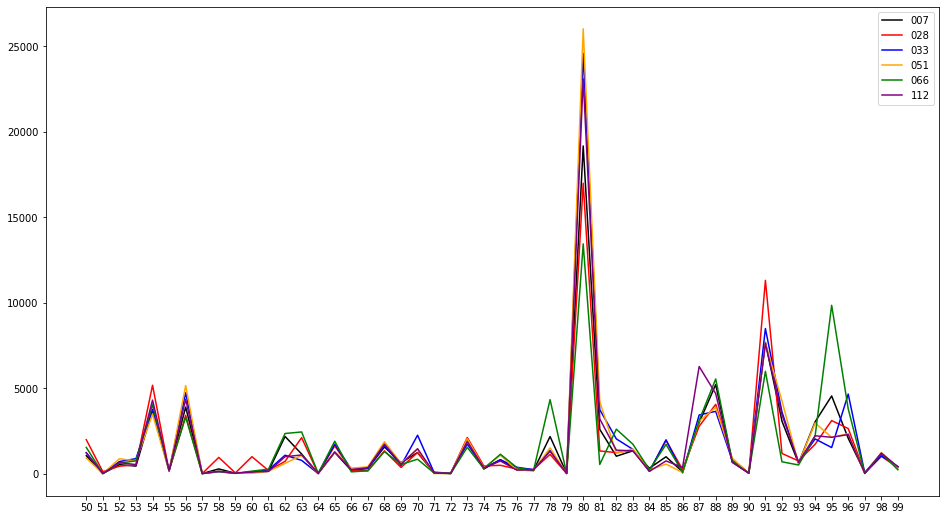

  ips_cell_line pred_VPN  exp_distance
1         028#1   B7_028         88.81
0         007#4   B7_007         91.06
4         066#8   B7_066         92.30
5         112#3   B7_112         95.90
3         051#1   B7_051         97.86
2         033#1   B7_033        100.00


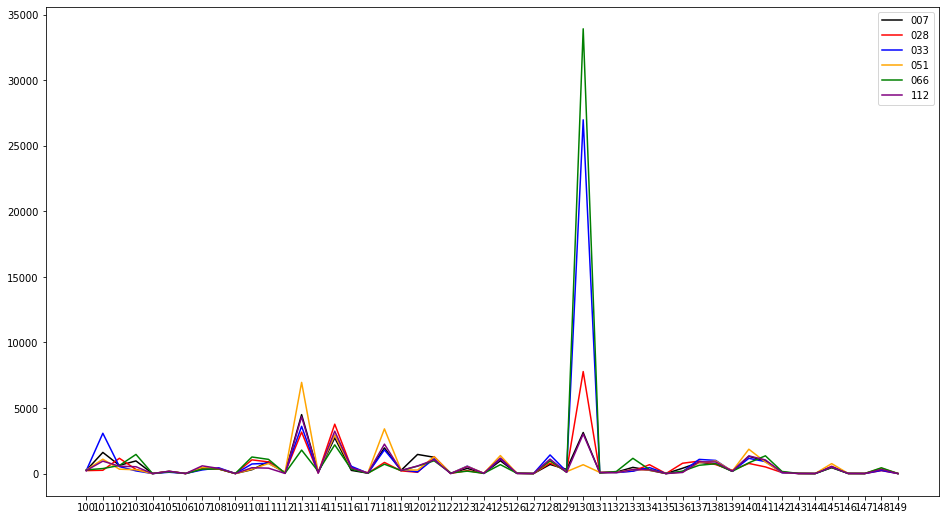

  ips_cell_line pred_VPN  exp_distance
5         112#3   B7_112         51.39
0         007#4   B7_007         53.94
3         051#1   B7_051         54.70
1         028#1   B7_028         55.42
2         033#1   B7_033         96.08
4         066#8   B7_066        100.00


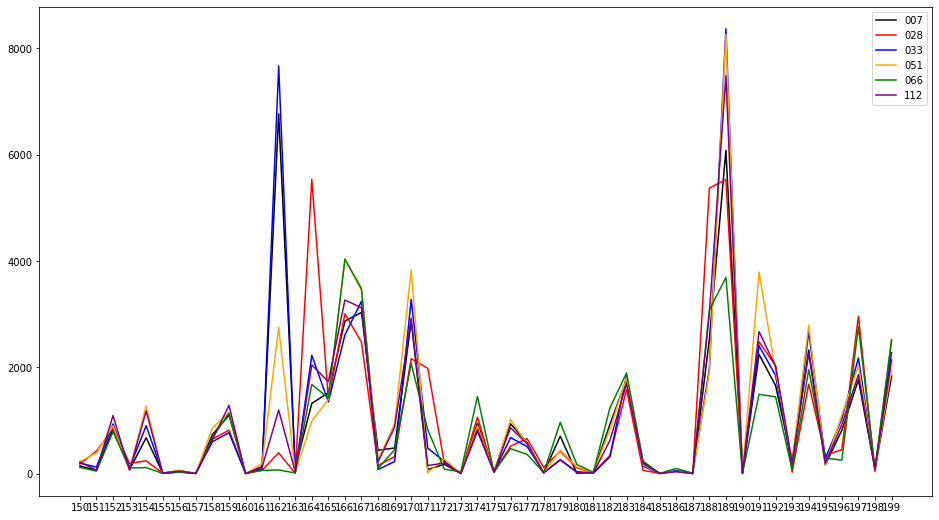

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         78.75
5         112#3   B7_112         90.99
0         007#4   B7_007         92.75
1         028#1   B7_028         92.82
2         033#1   B7_033         99.76
3         051#1   B7_051        100.00


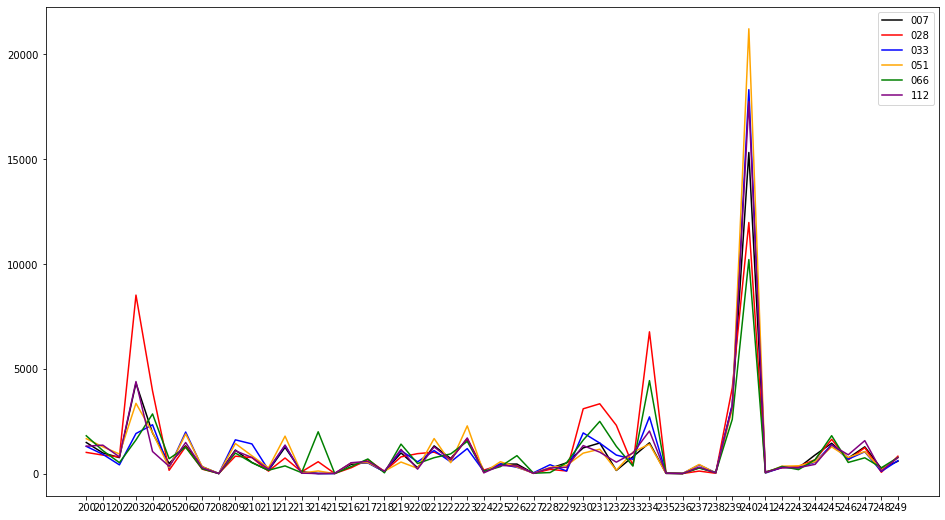

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         77.96
0         007#4   B7_007         80.26
5         112#3   B7_112         84.39
2         033#1   B7_033         85.49
3         051#1   B7_051         90.58
1         028#1   B7_028        100.00


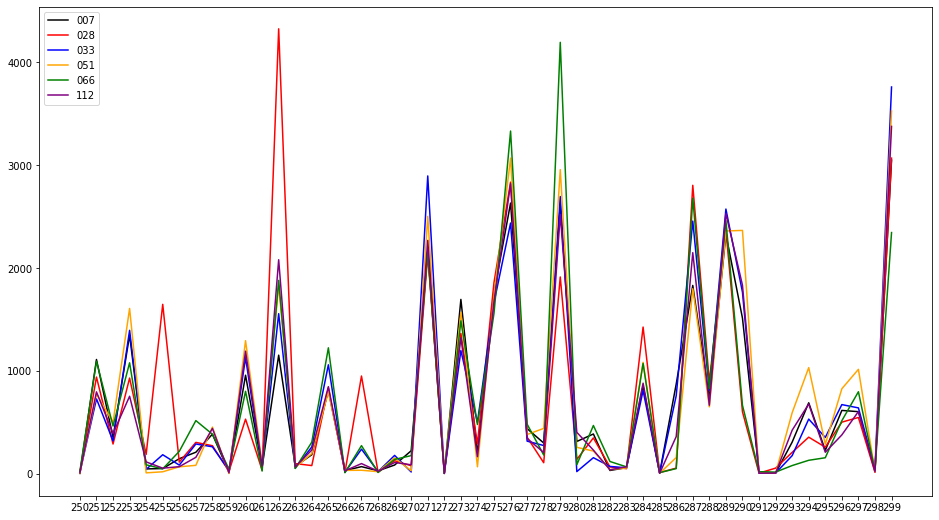

  ips_cell_line pred_VPN  exp_distance
0         007#4   B7_007         90.60
5         112#3   B7_112         91.13
4         066#8   B7_066         95.24
2         033#1   B7_033         95.92
1         028#1   B7_028         98.22
3         051#1   B7_051        100.00


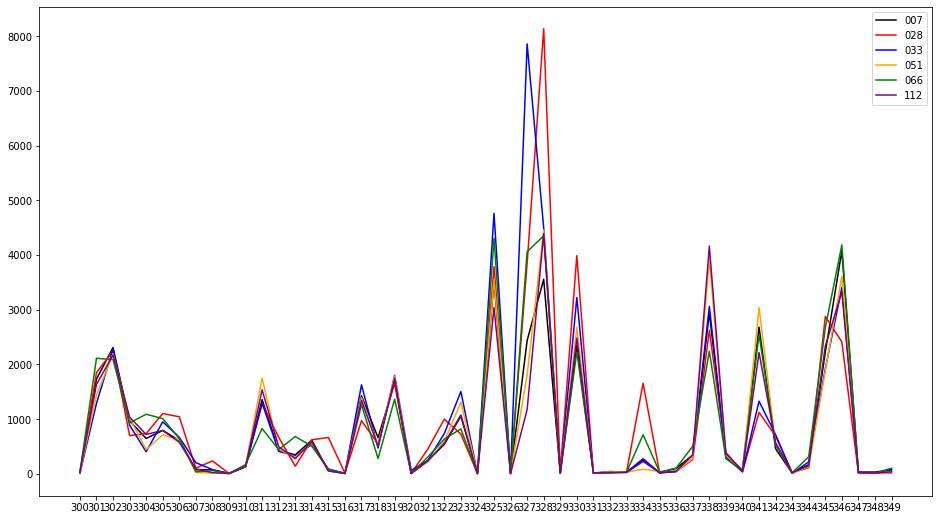

  ips_cell_line pred_VPN  exp_distance
5         112#3   B7_112         82.72
0         007#4   B7_007         84.37
3         051#1   B7_051         85.82
4         066#8   B7_066         91.00
2         033#1   B7_033         98.09
1         028#1   B7_028        100.00


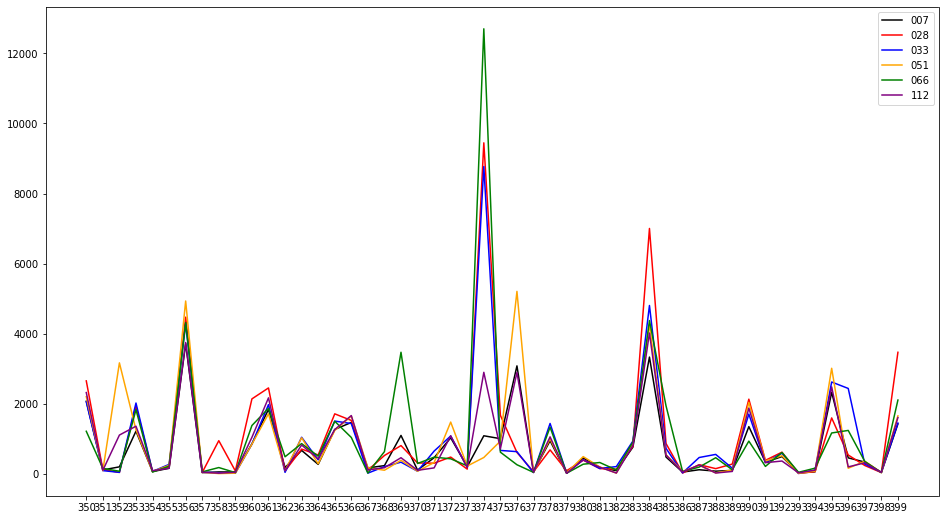

  ips_cell_line pred_VPN  exp_distance
0         007#4   B7_007         66.74
5         112#3   B7_112         74.00
3         051#1   B7_051         82.05
2         033#1   B7_033         89.29
4         066#8   B7_066         96.07
1         028#1   B7_028        100.00


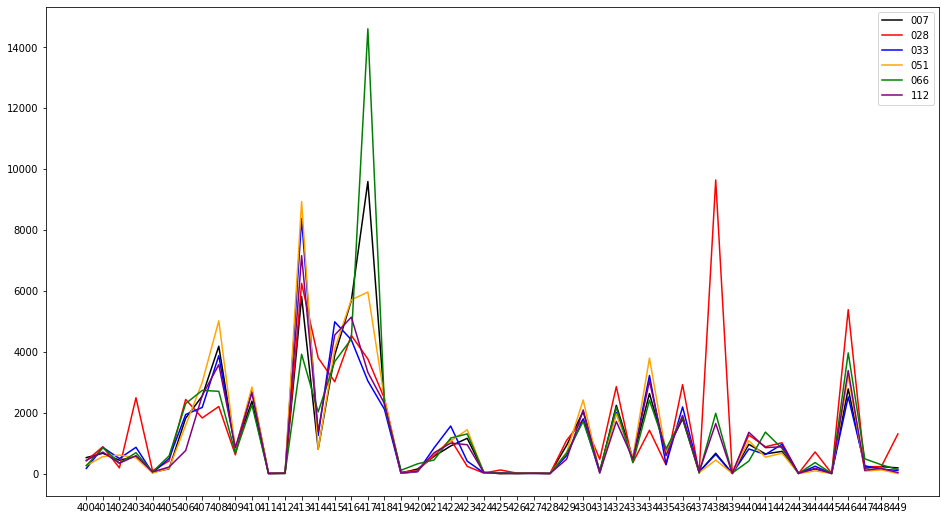

  ips_cell_line pred_VPN  exp_distance
5         112#3   B7_112         80.72
2         033#1   B7_033         80.91
0         007#4   B7_007         86.60
3         051#1   B7_051         89.83
4         066#8   B7_066         93.62
1         028#1   B7_028        100.00


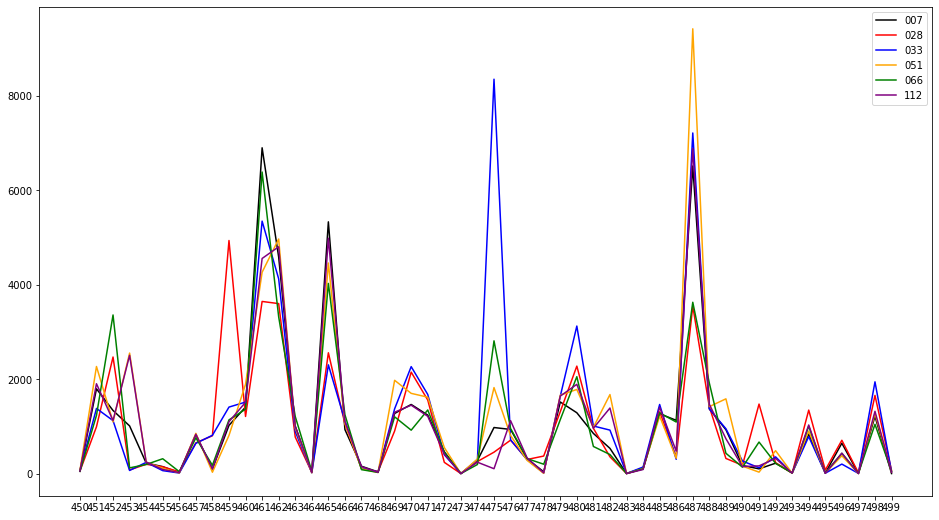

  ips_cell_line pred_VPN  exp_distance
1         028#1   B7_028         82.06
4         066#8   B7_066         84.93
0         007#4   B7_007         89.92
5         112#3   B7_112         90.09
3         051#1   B7_051         99.65
2         033#1   B7_033        100.00


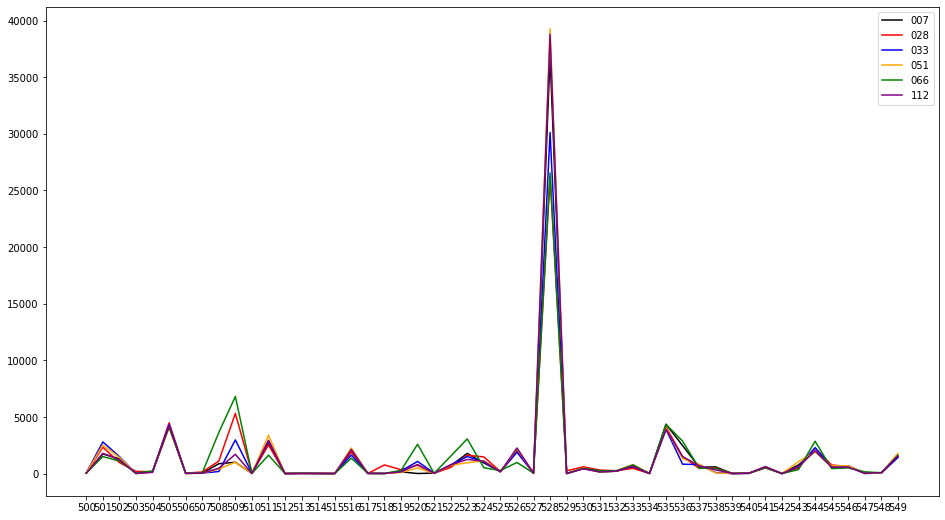

  ips_cell_line pred_VPN  exp_distance
2         033#1   B7_033         89.25
1         028#1   B7_028         90.40
0         007#4   B7_007         96.26
4         066#8   B7_066         97.03
5         112#3   B7_112         98.41
3         051#1   B7_051        100.00


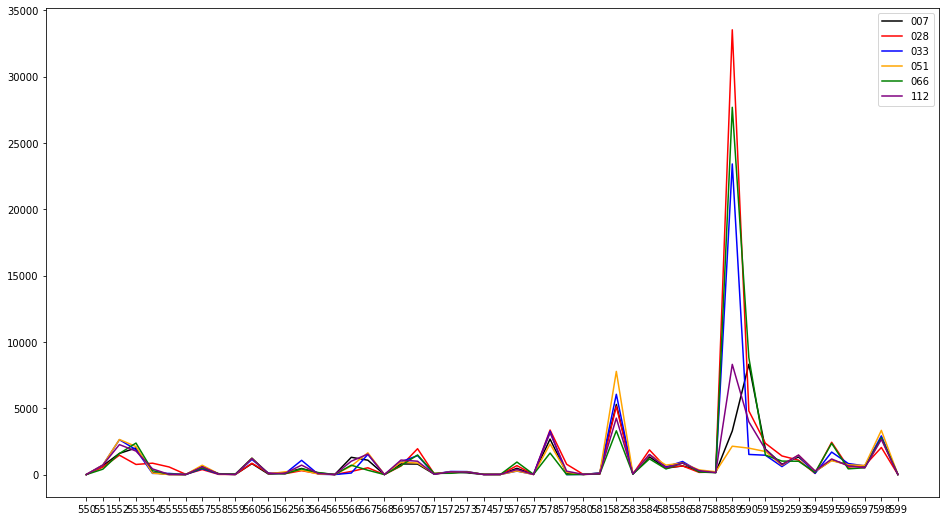

  ips_cell_line pred_VPN  exp_distance
3         051#1   B7_051         57.01
0         007#4   B7_007         60.59
5         112#3   B7_112         64.07
2         033#1   B7_033         84.04
4         066#8   B7_066         91.17
1         028#1   B7_028        100.00


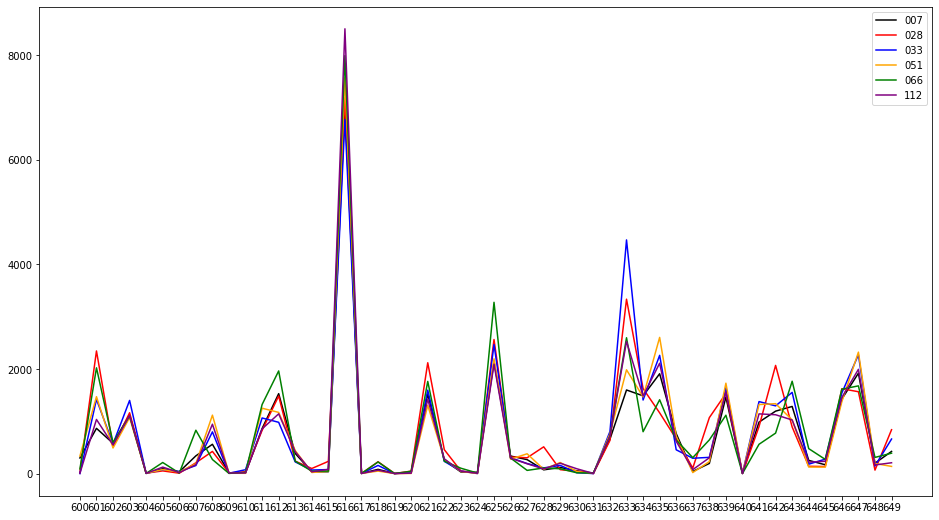

  ips_cell_line pred_VPN  exp_distance
0         007#4   B7_007         86.80
5         112#3   B7_112         92.00
3         051#1   B7_051         94.13
4         066#8   B7_066         97.79
1         028#1   B7_028         99.95
2         033#1   B7_033        100.00


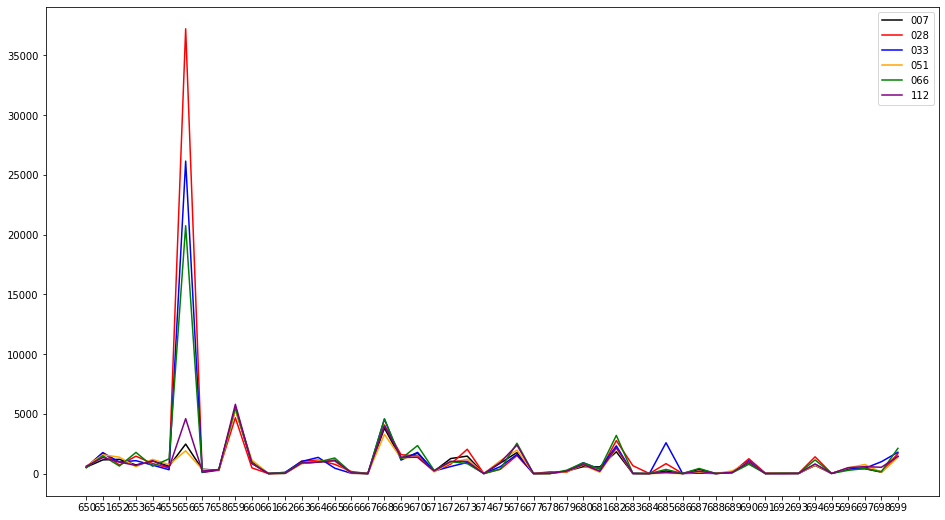

  ips_cell_line pred_VPN  exp_distance
3         051#1   B7_051         49.56
0         007#4   B7_007         50.71
5         112#3   B7_112         54.59
4         066#8   B7_066         81.38
2         033#1   B7_033         86.36
1         028#1   B7_028        100.00


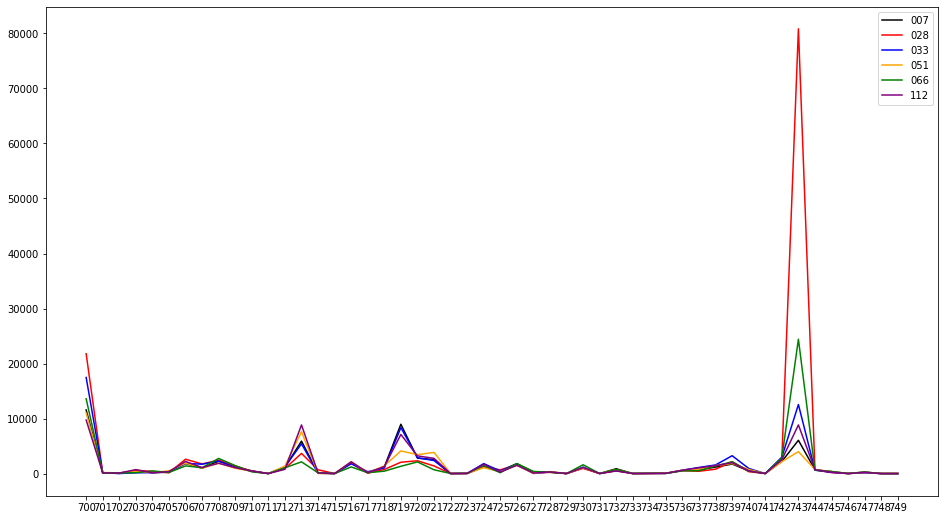

  ips_cell_line pred_VPN  exp_distance
3         051#1   B7_051         43.53
0         007#4   B7_007         46.14
5         112#3   B7_112         48.67
4         066#8   B7_066         50.86
2         033#1   B7_033         56.77
1         028#1   B7_028        100.00


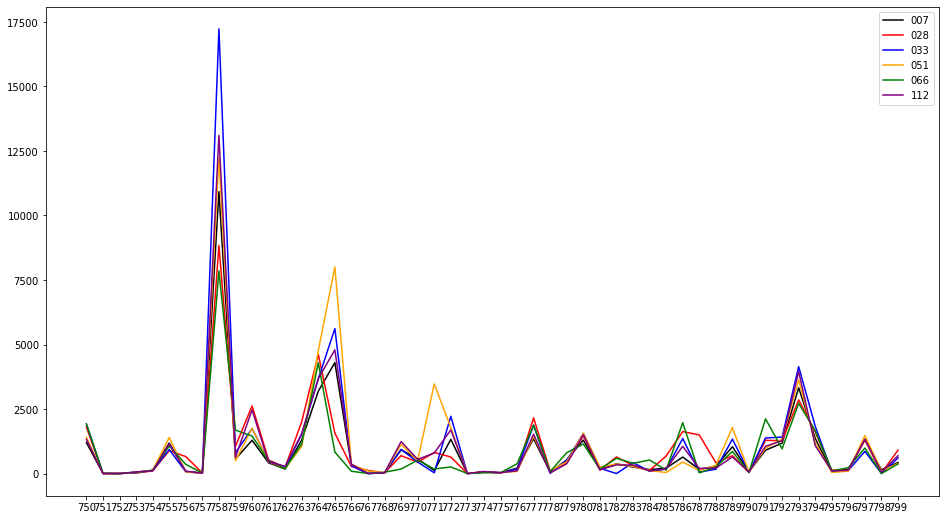

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         72.52
0         007#4   B7_007         77.18
1         028#1   B7_028         84.50
5         112#3   B7_112         89.65
3         051#1   B7_051         98.72
2         033#1   B7_033        100.00


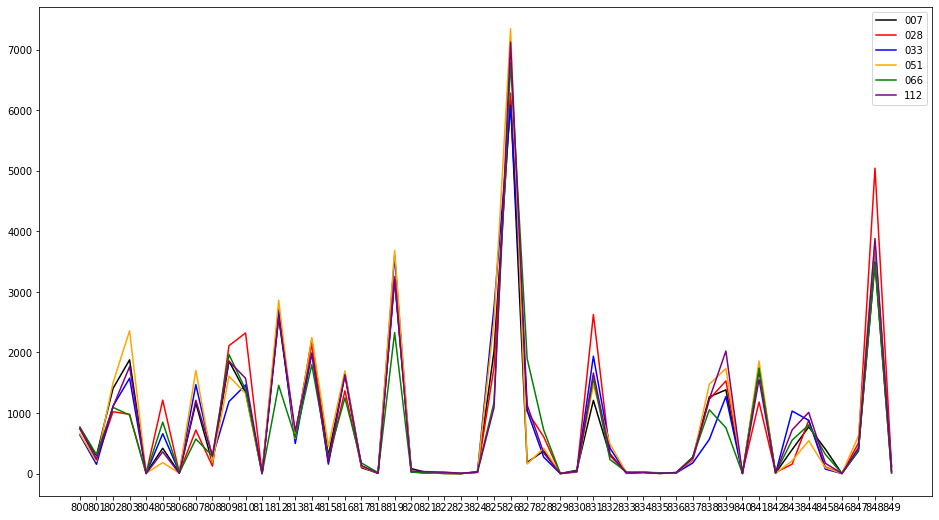

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         85.36
0         007#4   B7_007         91.15
2         033#1   B7_033         93.92
5         112#3   B7_112         96.04
1         028#1   B7_028         97.91
3         051#1   B7_051        100.00


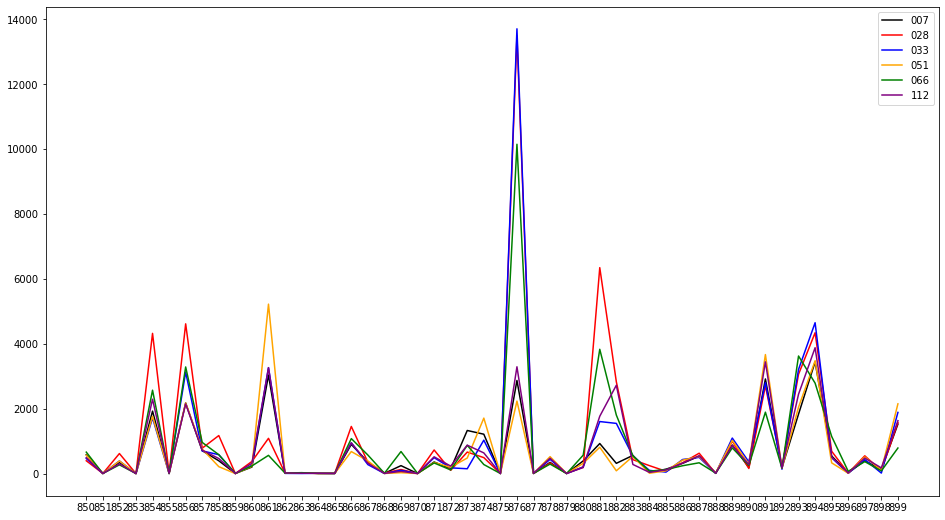

  ips_cell_line pred_VPN  exp_distance
0         007#4   B7_007         57.36
3         051#1   B7_051         60.96
5         112#3   B7_112         65.94
4         066#8   B7_066         76.08
2         033#1   B7_033         84.60
1         028#1   B7_028        100.00


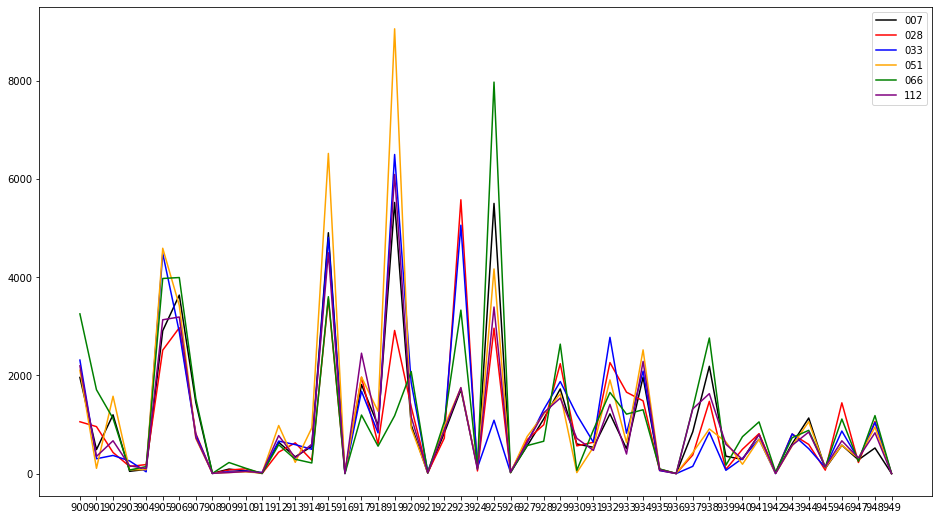

  ips_cell_line pred_VPN  exp_distance
1         028#1   B7_028         83.78
5         112#3   B7_112         87.10
0         007#4   B7_007         89.83
2         033#1   B7_033         92.29
3         051#1   B7_051         99.35
4         066#8   B7_066        100.00


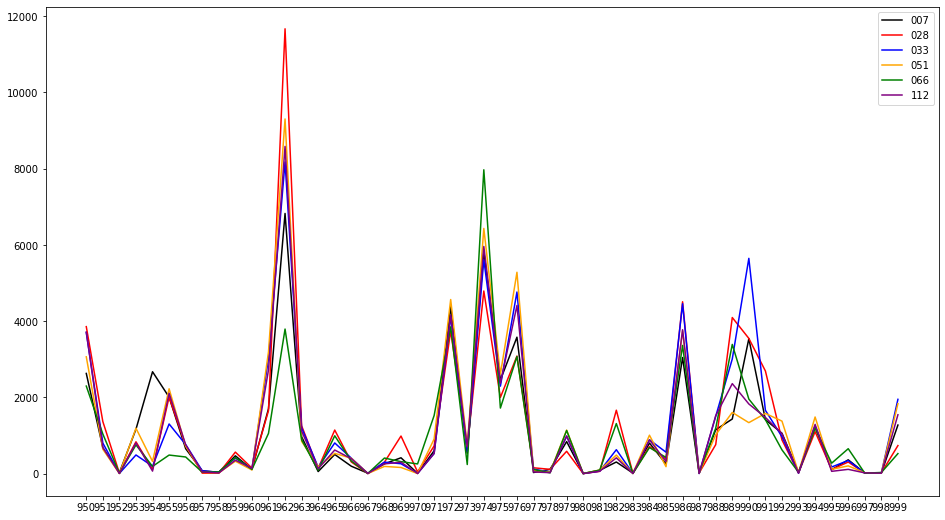

  ips_cell_line pred_VPN  exp_distance
4         066#8   B7_066         78.53
0         007#4   B7_007         86.50
5         112#3   B7_112         90.84
3         051#1   B7_051         94.97
2         033#1   B7_033         99.62
1         028#1   B7_028        100.00


In [36]:
win_len = 50
win_start_vals = range(0, 1000, win_len)
for win_start in win_start_vals:
    calc_dist_win(df_ips, df_pred, gene_intersection, win_start, win_len)

In [37]:
pred_exp = df_pred[gene_intersection].values
print(np.min(pred_exp), np.max(pred_exp))

-4.219126 2.6975441227201653


In [38]:
#add axonal growth value to df_dist to plot correlation betweeen exp_dist and axonal growth
df_dist["axonal_growth"] = 0
df_dist["axonal_growth"] = df_dist.apply(
    lambda row: df_pred[df_pred["VPN_col"] == row["pred_VPN"]].iloc[0]["axonal_growth"]
    , axis=1
)
df_dist

#add ips_condition to explore any relationship
df_dist["ips_condition"] = ""
df_dist["ips_condition"] = df_dist.apply(
    lambda row: df_ips[df_ips["cell_line_col"] == row["ips_cell_line"]].iloc[0]["condition"]
    , axis=1
)
df_dist

NameError: name 'df_dist' is not defined

In [ ]:
cell_lines = list(df_dist["ips_cell_line"].unique())
cell_lines

In [ ]:
df_plot_correlation(df_dist, x='axonal_growth', y= 'exp_distance', annotation_col='pred_VPN')
#print metadata to inspect
df_meta

In [ ]:
#export df_dist to use by webserver
#df_dist.to_csv("webserver/rna_pred/rna_pred/data/expression_distance.csv")